In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [2]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 224,
    "LEARNING_RATE": 1e-2,
    "N_EPOCHS": 40,
    "DROPOUT_RATE": 0.2,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 32,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 64,
    "NUM_CLASSES": 2,
}

In [251]:
train_directory = 'data'

In [334]:
dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    color_mode='rgb',
    batch_size= None,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 27558 files belonging to 2 classes.


In [335]:
class_names = dataset.class_names
class_names

['Parasitized', 'Uninfected']

In [336]:
class_names[0]

'Parasitized'

In [337]:
len(dataset)  # batch of 32 image so there are 645 len with batch of 32 image

27558

In [341]:
for images, labels in dataset.take(1):
    image_shape = images.shape
    print("Image shape:", image_shape)

Image shape: (224, 224, 3)


## Dataset Visualization

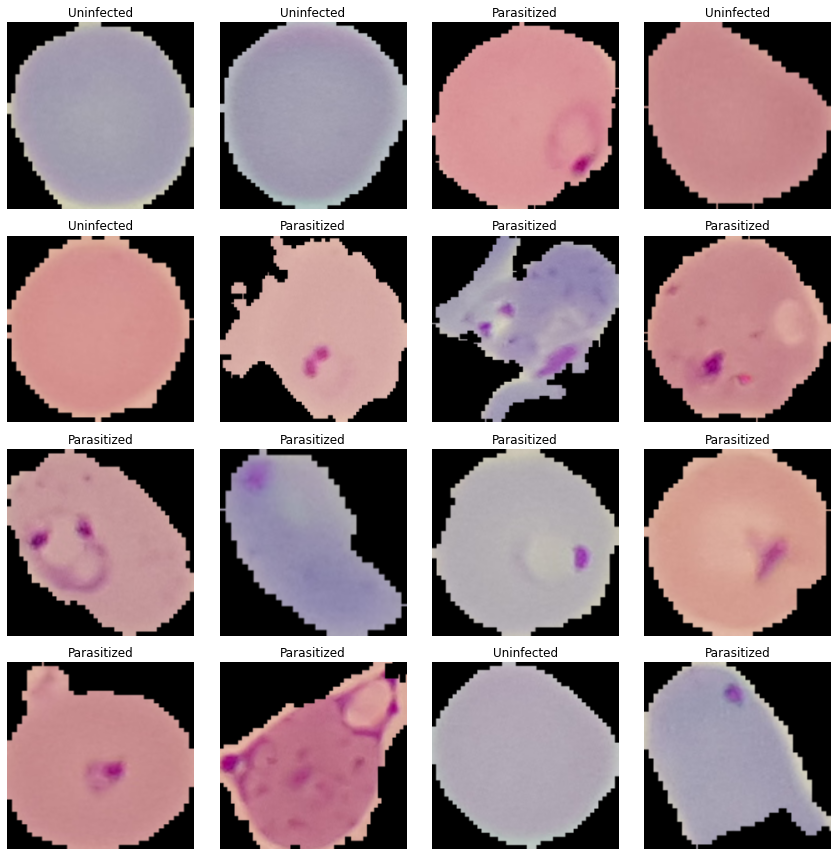

In [466]:
plt.figure(figsize=(12, 12))

for i, (image, label) in enumerate(dataset.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image / 255.)
    plt.title(class_names[label.numpy()])
    plt.axis("off")
    
plt.tight_layout()          # Adjust subplots to avoid overlapping

In [348]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [349]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32), 1)] [(array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
  

In [350]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [352]:
print(len(train_dataset),len(val_dataset),len(test_dataset))

22046 2755 2757


## Data Preprocessing

### Data Augmentation

In [353]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
       RandomRotation(factor = (0.25, 0.2501),),
       RandomFlip(mode='horizontal',)
                                  
])
@tf.function
def augment_layer_single_image(image, label):
  return augment_layers(resize_rescale_layers(image), training = True), label

In [354]:
### tf.keras.layer resizing and rescaling
IM_SIZE = CONFIGURATION['IM_SIZE']
resize_rescale_layers = tf.keras.Sequential([
       Resizing(IM_SIZE, IM_SIZE),
       Rescaling(1./255),                               
])

@tf.function
def resize_rescale_single_layer(image, label):
  return (resize_rescale_layers(image)), label

In [355]:
def visualize(original, augmented):
    fig = plt.figure(figsize=(8, 100))
    plt.subplot(1,2,1)
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.imshow(augmented)

In [362]:
original_image, label = next(iter(train_dataset))

In [363]:
original_image.shape

TensorShape([224, 224, 3])

In [364]:
preprocessed_original_image = resize_rescale_layers(original_image)

In [365]:
preprocessed_original_image.shape

TensorShape([224, 224, 3])

In [366]:
augmented_image = augment_layers(preprocessed_original_image, training = True)

In [367]:
augmented_image.shape

TensorShape([224, 224, 3])

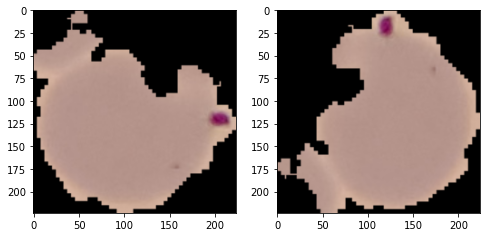

In [368]:
visualize(preprocessed_original_image, augmented_image)

# Data Loading

In [369]:
BATCH_SIZE = CONFIGURATION['BATCH_SIZE']

In [370]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(resize_rescale_single_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [371]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .map(resize_rescale_single_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [372]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [373]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

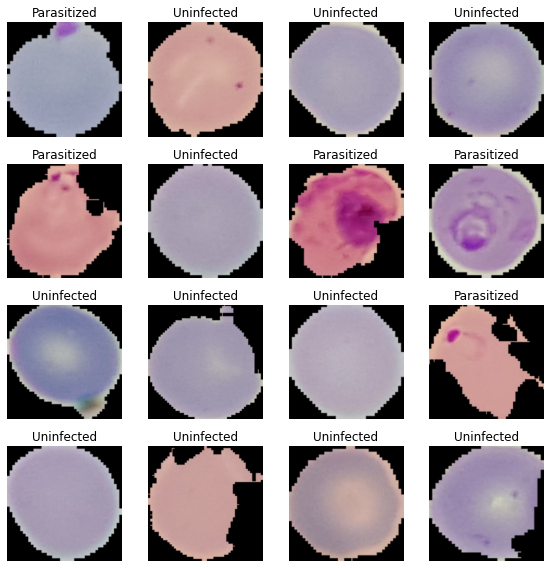

In [379]:
fig = plt.figure(figsize=(8, 8))

num_images = 16  # Set the desired number of images to display

for i, (image_batch, label_batch) in enumerate(train_dataset.take(1)):
    for j in range(16):
        ax = plt.subplot(4, 4, j + 1)
        
        image = image_batch[j]
        plt.imshow(image)
        plt.title(class_names[label_batch[j]])
        plt.axis('off')

plt.tight_layout()


# Model Creation and Training

# custom model

In [380]:
IM_SIZE = 224
class NeuralDense(Layer):
  def __init__(self, output_units, activation):
    super(NeuralDense, self).__init__()
    self.output_units = output_units
    self.activation = activation
  
  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1], self.output_units), initializer = "random_normal", trainable = True)
    self.b = self.add_weight(shape = (self.output_units,), initializer = "random_normal", trainable = True)
  
  def call(self, input_features):

    pre_output = tf.matmul(input_features, self.w) + self.b

    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)

    elif(self.activation == "sigmoid"):
      return tf.math.sigmoid(pre_output)

    else:
      return pre_output

In [381]:
import tensorflow as tf

class CustomConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid', activation=None):
        super(CustomConvLayer, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.conv_weights = self.add_weight(
            name='conv_weights',
            shape=(self.kernel_size[0], self.kernel_size[1], input_shape[-1], self.filters),
            initializer='random_normal',
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.filters,),
            initializer='zeros',
            trainable=True
        )

    def call(self, inputs):
        output = tf.nn.conv2d(
            inputs,
            self.conv_weights,
            strides=(1, self.strides[0], self.strides[1], 1),
            padding=self.padding.upper()
        )
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output


In [383]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

In [395]:
custom_model = tf.keras.Sequential([
                             InputLayer(input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
                        
                             augment_layers,
                                
                             CustomConvLayer(filters=N_FILTERS, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), strides=(N_STRIDES, N_STRIDES), padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size = POOL_SIZE, strides= N_STRIDES*2),
    
                             CustomConvLayer(filters=N_FILTERS*2, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), strides=(N_STRIDES, N_STRIDES), padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size = POOL_SIZE, strides= N_STRIDES*2),
                             Dropout(rate = DROPOUT_RATE ),
    
                             CustomConvLayer(filters=N_FILTERS*2, kernel_size=(KERNEL_SIZE, KERNEL_SIZE), strides=(N_STRIDES, N_STRIDES), padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size = POOL_SIZE, strides= N_STRIDES*2),
                             Dropout(rate = DROPOUT_RATE ),

                             Flatten(),
                             
                             NeuralDense(CONFIGURATION['N_DENSE_1'], activation = "relu"),
                             BatchNormalization(),
                             Dropout(rate = DROPOUT_RATE*2),
                             
                             NeuralDense(CONFIGURATION['N_DENSE_1'], activation = "relu"),
                             BatchNormalization(),

                             NeuralDense(1, activation = "sigmoid"),

])
custom_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (224, 224, 3)             0         
                                                                 
 custom_conv_layer_15 (Custo  (None, 222, 222, 32)     896       
 mConvLayer)                                                     
                                                                 
 batch_normalization_25 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 custom_conv_layer_16 (Custo  (None, 109, 109, 64)     18496     
 mConvLayer)                                         

# Callbacks

### CSVLogger

In [396]:
csv_callback = CSVLogger(
    'logs.csv', separator=',', append=True
)

### EarlyStopping

In [398]:
es_callback = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

### ReduceLearningRateOnPlateau

In [399]:
# this is another type of call back
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=3, verbose=1
)

# Training

In [400]:
custom_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = BinaryCrossentropy(),
      metrics = 'accuracy')

In [401]:
history = custom_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[es_callback, plateau_callback, csv_callback]
    )

Epoch 1/40
689/689 [==============================] - 1262s 2s/step - loss: 0.3565 - accuracy: 0.8478 - val_loss: 0.2281 - val_accuracy: 0.9260 - lr: 0.0100
Epoch 2/40
689/689 [==============================] - 1389s 2s/step - loss: 0.1968 - accuracy: 0.9377 - val_loss: 0.1818 - val_accuracy: 0.9416 - lr: 0.0100
Epoch 3/40
689/689 [==============================] - 946s 1s/step - loss: 0.1737 - accuracy: 0.9467 - val_loss: 0.2121 - val_accuracy: 0.9470 - lr: 0.0100
Epoch 4/40
689/689 [==============================] - 950s 1s/step - loss: 0.1661 - accuracy: 0.9496 - val_loss: 0.1565 - val_accuracy: 0.9539 - lr: 0.0100
Epoch 5/40
689/689 [==============================] - 968s 1s/step - loss: 0.1540 - accuracy: 0.9509 - val_loss: 0.1495 - val_accuracy: 0.9572 - lr: 0.0100
Epoch 6/40
689/689 [==============================] - 984s 1s/step - loss: 0.1574 - accuracy: 0.9493 - val_loss: 0.1742 - val_accuracy: 0.9608 - lr: 0.0100
Epoch 7/40
689/689 [==============================] - 974s 1s/

In [403]:
# Custom Loss
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self, FACTOR=1):
    super(CustomBCE, self).__init__()
    self.FACTOR = FACTOR
  def call(self, y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred)* self.FACTOR

In [404]:
class CustomAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='Custom_Accuracy', FACTOR=1):
        super(CustomAccuracy, self).__init__(name=name)
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name='accuracy', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.math.round(y_pred), dtype=tf.int32)
        accuracy = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))
        self.accuracy.assign_add(accuracy)
        self.total_samples.assign_add(tf.cast(tf.shape(y_true)[0], dtype=tf.float32))


    def result(self):
        return self.accuracy / self.total_samples

    def reset_states(self):
        self.accuracy.assign(0.)
        self.total_samples.assign(0.)

In [405]:
lenet_custom_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = CustomBCE(),
      metrics = CustomAccuracy())

In [406]:
history = lenet_custom_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    #callbacks=[LogImagesCallbackWandB()]
    )

Epoch 1/40
 28/689 [>.............................] - ETA: 16:34 - loss: 0.1908 - Custom_Accuracy: 0.9408

KeyboardInterrupt: 

# Custom Training Loop

In [408]:
def custom_bce(y_true, y_pred):
  bce = BinaryCrossentropy()
  return bce(y_true, y_pred)

In [409]:
METRIC = tf.keras.metrics.BinaryAccuracy(name='accuracy')
@tf.function
def training_block(x_batch, y_batch):
    with tf.GradientTape() as recorder:
        y_pred = lenet_custom_model(x_batch, training = True)
        loss = CustomBCE()(y_batch, y_pred)

  #wandb.log({'loss':loss.numpy()})
    partial_derivatives = recorder.gradient(loss, lenet_custom_model.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_custom_model.trainable_weights))
    METRIC.update_state(y_batch, y_pred)
    return loss


In [410]:
def neuralearn(model, loss_function, METRIC, OPTIMIZER, train_dataset, EPOCHS):
    for epoch in range(EPOCHS):
        print("Training starts for epoch number {}".format(epoch+1))
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            loss = training_block(x_batch, y_batch)
            if  step % 50 == 0:
                print("batch Training Loss", loss)
                print("batch The accuracy is: ", METRIC.result().numpy())
    
        print('===================================')
        print("Training Loss", loss)
        print("The accuracy is: ", METRIC.result().numpy())
      
        METRIC.reset_states()

        print("Training Complete!!!!")

In [411]:
OPTIMIZER = Adam(learning_rate = CONFIGURATION['LEARNING_RATE'])

In [412]:
neuralearn(lenet_custom_model, CustomBCE, METRIC, OPTIMIZER, train_dataset, 12)

Training starts for epoch number 1
batch Training Loss tf.Tensor(0.1981602, shape=(), dtype=float32)
batch The accuracy is:  0.90625
batch Training Loss tf.Tensor(0.15326492, shape=(), dtype=float32)
batch The accuracy is:  0.9252451
batch Training Loss tf.Tensor(0.06225481, shape=(), dtype=float32)
batch The accuracy is:  0.9322401


KeyboardInterrupt: 

# Transfer Learning EfficientNet

In [433]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [434]:
backbone.trainable = False

In [435]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    augment_layers,
    
    backbone,
    
    GlobalAveragePooling2D(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( 1, activation = 'sigmoid'),
    
    ])
pretrained_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (224, 224, 3)             0         
                                                                 
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_4   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 128)               229504    
                                                                 
 batch_normalization_38 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 64)              

In [431]:
pretrained_model.compile(optimizer = Adam(learning_rate = 0.0001),
      loss = BinaryCrossentropy(),
      metrics = 'accuracy')

In [432]:
history = pretrained_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[es_callback, csv_callback]
    )

Epoch 1/40
155/689 [=====>........................] - ETA: 17:43 - loss: 0.7001 - accuracy: 0.5083

KeyboardInterrupt: 

# Visulization

In [ ]:
print(history.history.keys())

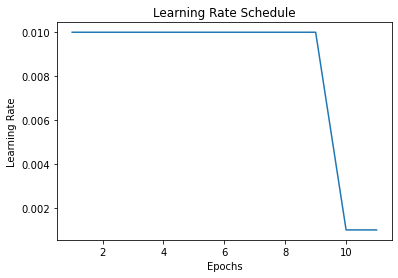

In [402]:
#import matplotlib.pyplot as plt

# Assuming you have a training history object named 'history'
lr_values = history.history['lr']  # Extract the learning rate values from the history

# Create a list of epochs corresponding to the learning rate values
epochs = range(1, len(lr_values) + 1)

# Plotting the learning rate
plt.plot(epochs, lr_values)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()


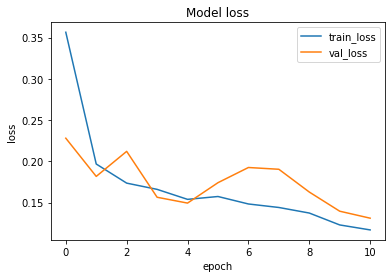

In [436]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

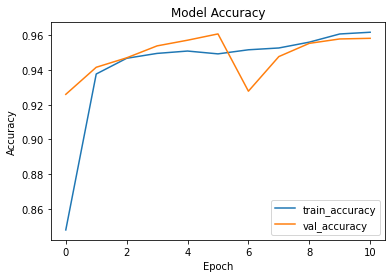

In [438]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# **Model Evaluation and Testing**

In [439]:
test_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [440]:
test_dataset1 = (
    test_dataset
    .map(resize_rescale_single_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [441]:
test_dataset1

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [443]:
custom_model.evaluate(test_dataset1)

87/87 [==============================] - 36s 233ms/step - loss: 0.1387 - accuracy: 0.9612


[0.1387459933757782, 0.9611896872520447]

## Visualizing Confusion Matrix

In [445]:
true_labels = []
predicted_labels = []

for image, label in test_dataset:
    true_labels.append(label.numpy())
    
    input_img = resize_rescale_layers(image)
    input_image = tf.expand_dims(input_img, axis=0)
    prediction = custom_model.predict(input_image)
    
    predicted_label = 0 if prediction < 0.5 else 1

    predicted_labels.append(predicted_label)


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


In [446]:
len(predicted_labels)

2757

In [447]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [448]:
cm = confusion_matrix(true_labels, predicted_labels)

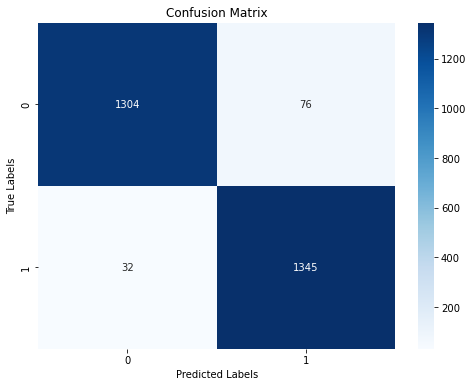

In [449]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Make predictions on imported image

In [450]:
# Make predictions
sample_image_path = 'image.png'  # Path to the sample image you want to predict



In [ ]:
sample_image = tf.keras.preprocessing.image.load_img(
    sample_image_path
)

In [ ]:
img = np.array(sample_image)

In [ ]:
img.shape

In [ ]:
plt.imshow(img)

In [ ]:
img = resize_rescale_layers(img)

In [ ]:
img = tf.expand_dims(img, axis=0)

In [ ]:
print(img.shape)

In [ ]:
model_seq.predict(img)

In [ ]:
prediction = model_seq.predict(img)
predicted_class = 'parasitized' if prediction < 0.5 else 'uninfected'

print('Prediction:', predicted_class)

## ROC Plots

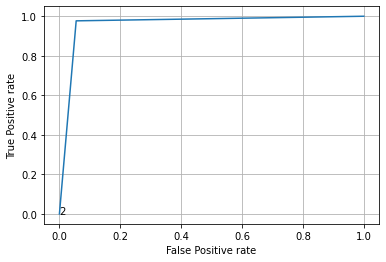

In [451]:
fp, tp, thresholds = roc_curve(true_labels, predicted_labels)
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.grid()

skip = 20

for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
  
plt.show()

In [452]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [453]:
parasite_or_not(custom_model.predict(test_dataset1)[0][0])

87/87 [==============================] - 23s 203ms/step


'P'

1/1 [==============================] - 0s 202ms/step


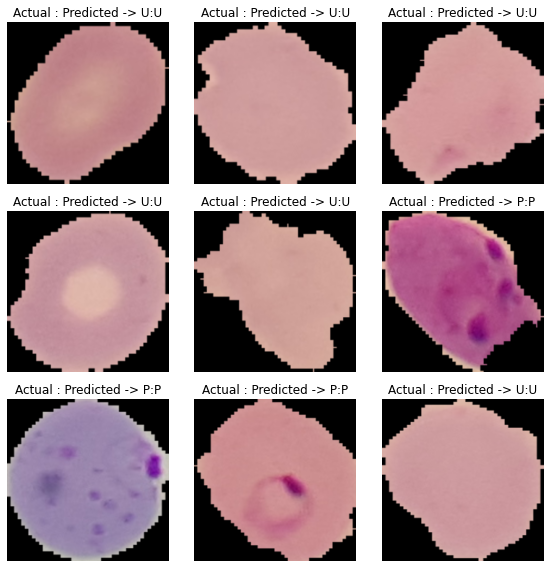

In [455]:
fig = plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(test_dataset1.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title('Actual : Predicted -> ' + str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(custom_model.predict(image)[0])))
  
  plt.axis('off')

plt.tight_layout()

In [464]:
tf.saved_model.save(custom_model, 'model_final')

AttributeError: 'NoneType' object has no attribute 'replace'

In [460]:
model = tf.keras.models.load_model("model_fin.hdf5")
model.summary()

ValueError: Unknown layer: 'CustomConvLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.